In [1]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

using StatsBase
using SparseArrays
using SpecialFunctions

 Activating environment at `~/hypergraph_modularities_code/Project.toml`
┌ Info: Precompiling HypergraphModularity [0c934d27-dd44-49d7-950f-bd4be7819e54]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphModularity does not have SpecialFunctions in its dependencies:
│ - If you have HypergraphModularity checked out for development and have
│   added SpecialFunctions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphModularity
└ Loading SpecialFunctions into HypergraphModularity from project dependency, future warnings for HypergraphModularity are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `HypergraphModularity.ConstructAdj :: Tuple{SparseArrays.SparseMatrixCSC,Int64}` in module `HypergraphModularity`
└ @ Base.Docs docs/Docs.jl:229
 

In [2]:
# dataset = "contact-primary-school-classes"
dataset = "email-Enron-full"
# dataset = "walmart-trips"
# dataset = "TrivagoClickout"
kmax_ = 38

H = read_hypergraph_data(dataset,kmax_, 2, false)
α = zeros(2*kmax_);

kmax = maximum(keys(H.E))
kmin = minimum(keys(H.E))

n = length(H.D)

# all-or-nothing
function ω(p,α)
    k = p[2]
    δ = p[1]
    return ((1+(1-δ))*n)^α[k] / (n^α[k + kmax])
end

Ω = allOrNothingIntensityFunction(ω, kmax);

In [3]:
α̂ = α
verbose = false
maxits = 100
randflag = true
weighted=false

# Zwarm = collect(1:n)  # no warm start

println("")

println("DYADIC")
print(rpad("iteration", 20))
print(rpad("L_D", 15))
print(rpad("Q", 15))
print(rpad("NMI", 10))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  80, "-"))

Ẑ = collect(1:n)
Ẑ₁ = Ẑ

γ = 5.0
for i = 1:10
    
    tic = time()
    
    Ẑ = CliqueExpansionModularity(H, γ, false, true);
    toc = time()-tic
    
    γ = computeDyadicResolutionParameter(H, Ẑ)
    ω_in, ω_out = computeDyadicResolutionParameter(H, Ẑ; mode="ω", weighted=weighted)
    Ω = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
    Q = modularity(H, Ẑ, Ω; α = α̂)
    
    L_D = dyadicLogLikelihood(H, Ẑ, ω_in, ω_out; constants = true)
    
    print(rpad("$i", 20))
    print(rpad("$(round(L_D))", 15))
    print(rpad("$(round(Q))", 15))
    print(rpad("$(round(mutualInformation(Ẑ₁,Ẑ,true), digits = 2))", 10))
    print(rpad("$(length(unique(Ẑ)))", 10))
    println(rpad("$(round(toc; digits=3))", 10))
    
    Ẑ₁ = Ẑ
end


DYADIC
iteration           L_D            Q              NMI       groups    time (s)  
--------------------------------------------------------------------------------
1                   -4627.0        -29546.0       0.68      18        1.997     
2                   -7473.0        -29504.0       0.75      11        0.028     
3                   -9353.0        -29926.0       0.86      10        0.008     
4                   -9363.0        -29890.0       0.81      10        0.009     
5                   -11261.0       -30332.0       0.69      8         0.009     
6                   -11382.0       -30350.0       0.94      8         0.009     
7                   -11364.0       -30345.0       0.94      8         0.01      
8                   -11382.0       -30350.0       0.94      8         0.008     
9                   -11363.0       -30349.0       0.97      8         0.008     
10                  -11384.0       -30346.0       0.94      8         0.01      


In [4]:
D = countmap(Ẑ₁)
[(key, val) for (key, val) in D if val > 1]

3-element Array{Tuple{Int64,Int64},1}:
 (7, 15)
 (2, 43)
 (1, 85)

In [17]:
α̂ = α
verbose = false
maxits = 100
randflag = true

bigNums = false

# Zwarm = collect(1:n)  # no warm start
Z_ = CliqueExpansionModularity(H, 15.0);

Ẑ = Z_
Ẑ₂ = Z_
Ω = estimateΩEmpirically(H, Ẑ₂; aggregator = p -> [length(p) == 1, sum(p)], bigNums = bigNums)
Q = modularity(H, Z_, Ω; α = α)
println("Warmstart partition has $(maximum(Z_)) clusters and modularity $(round(Q)).")
println("")

println("POLYADIC")
print(rpad("iteration", 20))
print(rpad("Q", 15))
print(rpad("NMI", 10))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  65, "-"))

for i = 1:10
    
#     γ = computeDyadicResolutionParameter(H, Ẑ)
#     Z_ = CliqueExpansionModularity(H, γ);
    Z_ = collect(1:n)
    
    tic = time()
    Ẑ₂ = SuperNode_PPLouvain(H, Ω; α = α, verbose = false, Z0 = Z_)
    toc = time()-tic
        
    Ω = estimateΩEmpirically(H, Ẑ₂; aggregator = p -> [length(p) == 1, sum(p)], bigNums = bigNums)
    Q = modularity(H, Ẑ₂, Ω; α = α̂)
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q))", 15))
    print(rpad("$(round(mutualInformation(Ẑ₂,Ẑ,true), digits = 2))", 10))
    print(rpad("$(length(unique(Ẑ₂)))", 10))
    println(rpad("$(round(toc; digits=3))", 10))
    
    Ẑ = Ẑ₂
end

Warmstart partition has 41 clusters and modularity -30414.0.

POLYADIC
iteration           Q              NMI       groups    time (s)  
-----------------------------------------------------------------
1                   -29902.0       0.83      32        0.146     
2                   -29845.0       0.86      27        0.064     
3                   -29647.0       0.8       22        0.057     
4                   -29338.0       0.78      17        0.089     
5                   -29477.0       0.85      19        0.058     
6                   -29363.0       0.92      17        0.049     
7                   -29389.0       0.94      17        0.054     
8                   -29416.0       0.92      16        0.047     
9                   -29396.0       0.86      17        0.053     
10                  -29439.0       0.86      17        0.051     


In [13]:
D = countmap(Ẑ₂)
[(key, val) for (key, val) in D if val > 1]

15-element Array{Tuple{Int64,Int64},1}:
 (2, 9)
 (21, 2)
 (7, 16)
 (9, 15)
 (10, 5)
 (19, 8)
 (6, 10)
 (4, 22)
 (3, 8)
 (5, 10)
 (13, 3)
 (14, 4)
 (15, 4)
 (12, 15)
 (1, 9)

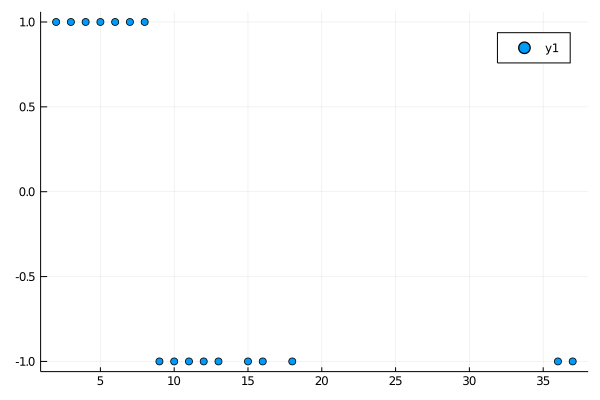

In [14]:
# plot the sign of the difference between the within- and between intensities. 

using Plots

K = [k for k in keys(H.E) if length(H.E[k]) > 0]

v = [(Ω.ω([1, k], α) - Ω.ω([0, k], α)) for k in K]

V = sign.(v)


plot(K, V, seriestype = :scatter)

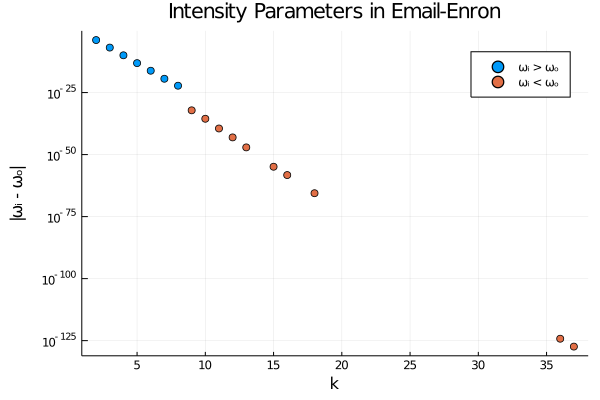

In [18]:
# plot the sign of the difference between the within- and between intensities. 

using Plots

K = [k for k in keys(H.E) if length(H.E[k]) > 0]

v = [(Ω.ω([1, k], α) - Ω.ω([0, k], α)) for k in K]

V = v

# plot(K, abs.(V), seriestype = :scatter, yaxis = :log)
plot(K[V .> 0], V[V .> 0], seriestype = :scatter, yaxis = :log, label = "ωᵢ > ωₒ")
plot!(K[V .< 0], abs.(V[V .< 0]), seriestype = :scatter, yaxis = :log, label = "ωᵢ < ωₒ")
xlabel!("k")
ylabel!("|ωᵢ - ωₒ|")
title!("Intensity Parameters in Email-Enron")

In [52]:
function q(k)
    Hk = hypergraph(1:n, Dict(k => H.E[k]), [0])
    HypergraphModularity.computeDegrees!(Hk)
    return modularity(Hk, Ẑ₂, Ω; α = α̂)
end

K = [k for k in keys(H.E) if length(H.E[k]) > 0]

Qvec = q.(K)

17-element Array{BigFloat,1}:
  -694.5657687329523285290580596660965908009886983967853277411642683000005859627857
  -302.0448153293563737218182934086488930443235935741695454532283986905636731040193
 -7961.9284082767545779954899802521861573723072069697082042694091796875
  -268.318695295574512354235563015962040296345868054128059946045306360428081714689
  -545.6330480381571301120404899912281292841325829107832924315838060237364699986152
 -1435.070754428899539735721924993293602314961580263847352266652304268544244479278
  -444.4418972955444059979597894148193229340882289852816813464235790568992013976544
  -901.1248346009481378130516249720055895860605712547930563615809000436465106192674
 -1317.417779514396837714631034519023643408414841867248594411665239974789528197816
 -1838.869462531760286343508802865416823090245094070659425925270953686856891627898
 -3537.686752972679517867860222560255997333017196983159227338666674711475934600458
  -293.45571925381835333882218005012026630615145570805256969243

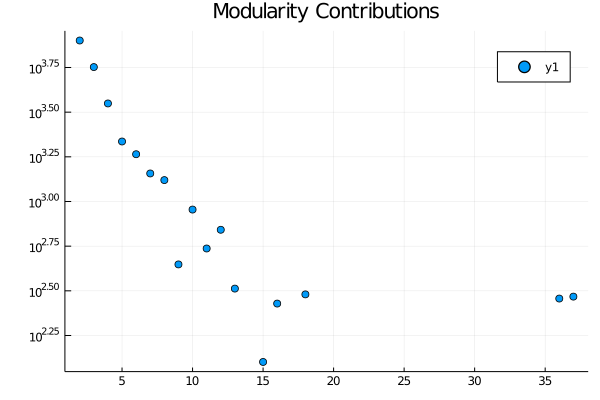

In [151]:
plot(collect(K), -Qvec, seriestype = :scatter, yaxis = :log)
title!("Modularity Contributions")